# Project: Investigate a Dataset - [No_show_appointments]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 
<br>This [dataset](https://www.kaggle.com/datasets/joniarroba/noshowappointments) collects information from 100K medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. 
- `PatientId`: **Identification** of a patient.
- `AppointmentId`: **Identification** of each appointment.
- `Gender`: **Male or Female**. Female is the greater proportion, woman takes way more care of their health in comparison to man.
- `ScheduledDay`: **Date**. What day the patient set up their appointment.
- `AppointmentDay`: **Date**. What day the patient is coming to the hospital.
- `Age`: **Numeric**. How old is the patient.
- `Neighbourhood`: **String**. Location of the hospital.
- `Scholarship`: **True or False**. Whether or not the patient is enrolled in Brasilian welfare program [Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Família).
- `Hipertension`: **True or False**.
- `Diabetes`: **True or False**.
- `Alcoholism`: **True or False**.
- `Handcap`: **True or False**.
- `SMS_received`: **True or False**.
- `No-show`: **True or False**. 'No' if the patient showed up to their appointment, and 'Yes' if they did not show up.

### Question(s) for Analysis: What factors are important for us to know in order to predict if a patient will not show up for their scheduled appointment?

In [1]:
# Use this cell to set up import statements for all of the packages that you plan to use.

import pandas as pd
import numpy as np
from datetime import date, timedelta
import scipy.stats.distributions as dist
import matplotlib.pyplot as plt

# downgrade jinja2 to avoid export error
# pip install -I jinja2==3.0.3

# While optional for current notebooks, if you are having trouble with visualizations,
#   remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

<a id='wrangling'></a>
## Data Wrangling
### General Properties

In [2]:
# Load your data and print out a few lines. What is the size of your dataframe? 
df = pd.read_csv("./Database_No_show_appointments/noshowappointments-kagglev2-may-2016.csv")
df.shape

(110527, 14)

In [3]:
#   Perform operations to inspect data types and look for instances of missing
#   or possibly errant data. There are at least 4 - 6 methods you can call on your
#   dataframe to obtain this information.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### Data Cleaning
We don't have missing data in this dataset, but several datatypes are incorrect. So our first cleaning decision is

**1. Change Data Types**
<br>Based on the datatypes we found above, change them as follows:
<br>`float64` -> `int64`: "PatientId"
<br>`string` -> `datetime`: "ScheduledDay", "AppointmentDay"
<br>`int64` -> `int16`: "Age"
<br>`string` -> `category`: "Gender", "Scholarship", "Hipertension", "Diabetes", "Alcoholism", "Handcap", "SMS_received", "No-show"

Then check the only numerical variable `Age` to see whether outliers exist.

In [4]:
# make a copy of the dataframe to save the original data
df_clean = df.copy()

In [5]:
# statistics for column `Age`
df_clean.Age.describe()

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

**2. Invalid `Age` Value and Outlier**
<br>When we access the age column, we found some invalid value (that is less than 0).

In [6]:
# find invalid age that is negative
df_clean[df_clean["Age"] < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


<AxesSubplot:>

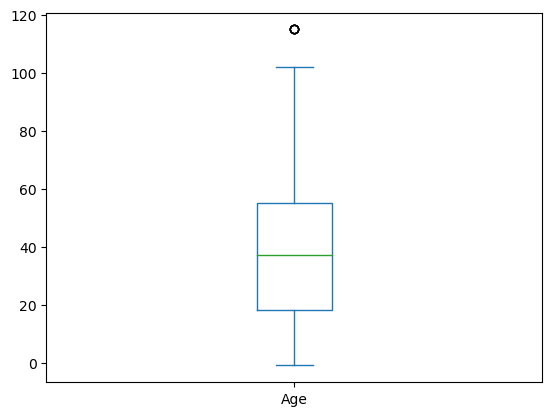

In [7]:
# find age outliers
df_clean.Age.plot(kind = "box")

Fortunately we only have one negative age and one large outlier, so we'll delete these two records.

In [8]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

In [9]:
# change data types
df_clean["PatientId"] = df_clean["PatientId"].astype("int64")
df_clean["ScheduledDay"] = pd.to_datetime(df_clean["ScheduledDay"])
df_clean["AppointmentDay"] = pd.to_datetime(df_clean["AppointmentDay"])
df_clean["Age"] = df_clean["Age"].astype("int16")

columns = ["Gender", "Scholarship", "Hipertension", "Diabetes", "Alcoholism", "Handcap", "SMS_received", "No-show"]
for col in columns:
    df_clean[col] = df_clean[col].astype("category")
    
# check the updated data types
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  int64              
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  category           
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int16              
 6   Neighbourhood   110527 non-null  object             
 7   Scholarship     110527 non-null  category           
 8   Hipertension    110527 non-null  category           
 9   Diabetes        110527 non-null  category           
 10  Alcoholism      110527 non-null  category           
 11  Handcap         110527 non-null  category           
 12  SMS_received    110527 non-null  category           
 13  No-show       

In [10]:
# delete the record with invalid age
age_q3 = df_clean["Age"].quantile(0.75)
age_q1 = df_clean["Age"].quantile(0.25)
IQR = age_q3 - age_q1
age_max = age_q3 + 1.5*IQR
outlier = df_clean[(df_clean["Age"] > age_max) | (df_clean["Age"] < 0)].index
outlier
df_clean = df_clean.drop(outlier).reset_index().drop("index", axis = 1)
df_clean.shape

(110521, 14)

**3. Create `DaystoAppointment` for Further Exploration**
<br>We calculate the days between Appointment Day and Scheduled Day, to further explore whether this factor is important to predict the probability of showing up.

In [11]:
# create `DastoAppointment` column and see sample values
df_clean["DaystoAppointment"] = df_clean["AppointmentDay"] - df_clean["ScheduledDay"]
df_clean[["PatientId", "AppointmentID", "DaystoAppointment"]].head()

,PatientId,AppointmentID,DaystoAppointment
0,29872499824296,5642903,-1 days +05:21:52
1,558997776694438,5642503,-1 days +07:51:33
2,4262962299951,5642549,-1 days +07:40:56
3,867951213174,5642828,-1 days +06:30:29
4,8841186448183,5642494,-1 days +07:52:37


However, the difference is not in a good numerical format. We transform it to the unit of one day.

In [12]:
# transform to numeric values (unit of one day)
df_clean["DaystoAppointment"] = df_clean["DaystoAppointment"]/np.timedelta64(1, 'D')
df_clean[["PatientId", "AppointmentID", "DaystoAppointment"]].head()

,PatientId,AppointmentID,DaystoAppointment
0,29872499824296,5642903,-0.776481
1,558997776694438,5642503,-0.672535
2,4262962299951,5642549,-0.679907
3,867951213174,5642828,-0.728831
4,8841186448183,5642494,-0.671794


Additionally, if patients scheduled the appointment at the same day, we get negative difference by the equation above. So change all `DaystoAppointment` to zero if it is the same day scheduled appointment.

In [13]:
# negative `DaystoAppointment` was the same-day appointment
df_clean.loc[df_clean["DaystoAppointment"] < 0, "DaystoAppointment"] = 0
df_clean[["PatientId", "AppointmentID", "DaystoAppointment"]].head()

,PatientId,AppointmentID,DaystoAppointment
0,29872499824296,5642903,0.0
1,558997776694438,5642503,0.0
2,4262962299951,5642549,0.0
3,867951213174,5642828,0.0
4,8841186448183,5642494,0.0


<a id='eda'></a>
## Exploratory Data Analysis
During this analysis, we will focus on the following dependent variable:
- `No-show`

For independent variables, we have two identification columns:
- `PatientId`
- `AppointmentID`

eight **categorical** columns (most of them are dummy values):
1. `Gender` - F, M
2. `Neignbourhood` - Locations
3. `Scholarship` - 1, 0
4. `Hipertension` - 1, 0
5. `Diabetes` - 1, 0
6. `Alcoholism` - 1, 0
7. `Handcap` - 0, 1, 2, 3, 4
8. `SMS_received` - 1, 0

one **numerical** columns:
- `Age`

and two **date** columns:
- `ScheduledDay`
- `AppointmentDay`

We have six dummy independent variables, and one categorical independent varible that only have five levels. To avoid duplicated code, we write functions below that can be applied repeatly for exploring how they correlates with `No-show` column.

In [14]:
# define a function 
# create a dictionary for categorical variables of their levels and probability of patients not showing up
def cat_NoShowProb(col):
    """
    INPUT
        col - (str) the column name of a categorical variable
    OUTPUT
        prob_dict - (dict) levels of `col` and corresponding probability of patients not showing up to appointment
    """
    prob_dict = {"level": [],
                 "prob": []}
    for level in df_clean[col].unique():
        df_level = df_clean[df_clean[col] == level]
        noshow_level = df_level[df_level["No-show"] == "Yes"]
        prob_noshow_level = len(noshow_level)/len(df_level)
        prob_dict["level"].append(level)
        prob_dict["prob"].append(prob_noshow_level)
    return prob_dict

In [15]:
# define a function
# plot a bar chart for categorical variables of their levels and probability of patients not showing up
def plot_NoShowProb(prob_dict):
    """
    INPUT
        prob_dict - (dict) categorical levels and corresponding probability of patients not showing up
    OUTPUT
        Displays a bar plot of the input dictionary
    """
    pd.DataFrame(prob_dict).plot(kind = "bar",
                                 x = "level",
                                 title = "Proportion of Not Showing Up",
                                 legend = False,
                                 xlabel = "level",
                                 ylabel = "Probability",
                                 rot = 0);

In [16]:
# define a function
# compute p-value that compares proportions of patients not showing up from two categorical variables
def twoTTest(col, t, f):
    """
    INPUT
        col - (str) column name of a categorical variable
        t - (str/int) level 1
        f - (str/int) level 2
    OUTPUT
        Print two group proportion t test result
    """
    col_dict = cat_NoShowProb(col)
    prob_0 = col_dict['prob'][0]
    prob_1 = col_dict['prob'][1]
    n_1 = df_clean[df_clean[col] == t].shape[0]
    n_0 = df_clean[df_clean[col] == f].shape[0]
    col_dict = cat_NoShowProb(col)
    assert n_1*col_dict['prob'][0] > 30, "Assumptions not met"
    assert n_1*col_dict['prob'][1] > 30, "Assumptions not met"
    assert n_0*col_dict['prob'][0] > 30, "Assumptions not met"
    assert n_0*col_dict['prob'][1] > 30, "Assumptions not met"
    variance = prob_1*(1-prob_1)
    prop = df_clean.groupby(col)["No-show"].agg([lambda x: np.mean(x == "Yes"), "size"])
    prop.columns = ["proportions", "total_counts"]
    standard_error = np.sqrt(variance*(1/prop.total_counts[0] + 1/prop.total_counts[1]))
    print("Sample Standard Error:", standard_error)
    best_estimate = (prop.proportions[0] - prop.proportions[1])
    print("The best estimate is:", best_estimate)
    hypothesized_estimate = 0
    test_stat = (best_estimate - hypothesized_estimate)/standard_error
    print("Computed Test Statistics is", test_stat)
    pvalue = 2*dist.norm.cdf(-np.abs(test_stat))
    print("Computed P-value is", pvalue)

### Does the Gender affect whether the patients will show up to their appointments?

In [17]:
df_clean.Gender.value_counts()

F    71834
M    38687
Name: Gender, dtype: int64

In [18]:
cat_NoShowProb("Gender")

{'level': ['F', 'M'], 'prob': [0.2031210847231116, 0.19967947889471915]}

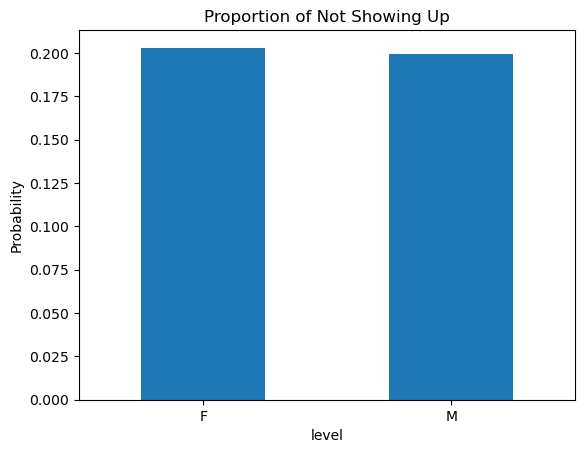

In [19]:
plot_NoShowProb(cat_NoShowProb("Gender"))

In [20]:
twoTTest("Gender", "F", "M")

Sample Standard Error: 0.0025210040577762346
The best estimate is: 0.003441605828392452
Computed Test Statistics is 1.365172665143695
Computed P-value is 0.1721987875706933


It looks like gender is not related to whether patients will show up to their appointments. Our t test result supports this conclusion.
### How many days scheduled before appointment day is more likely to result in a not showing up? 

In [21]:
df_clean["DaystoAppointment"].describe()

count    110521.000000
mean          9.869859
std          15.141423
min           0.000000
25%           0.000000
50%           3.474167
75%          14.320463
max         178.554873
Name: DaystoAppointment, dtype: float64

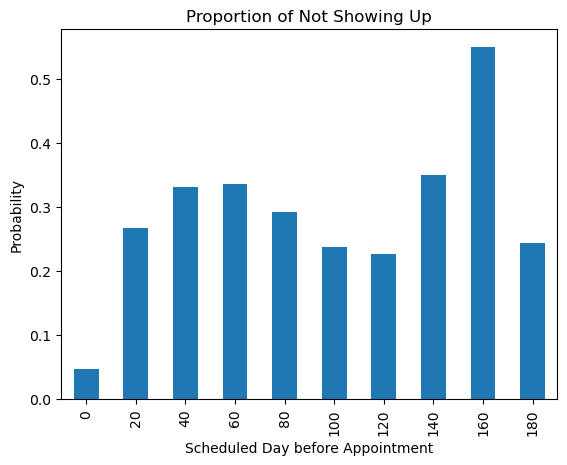

In [22]:
# organize `DaystoAppointment` to 20-day bins
days = np.arange(0, 181, 20)
prob_dict = {"Days": [],
             "Prob": []}
for i in range(len(days)):
    if i == 0:
        df_i = df_clean[df_clean["DaystoAppointment"] == 0]
        prob_noshow_i = len(df_i[df_i["No-show"] == "Yes"])/len(df_i)
        if len(df_i) > 0:
            prob_noshow_i = len(df_i[df_i["No-show"] == "Yes"])/len(df_i)
            prob_dict["Days"].append(days[i])
            prob_dict["Prob"].append(prob_noshow_i)
        else:
            prob_dict["Days"].append(days[i])
            prob_dict["Prob"].append(0)
    else:
        df_i = df_clean.loc[(df_clean["DaystoAppointment"] > days[i-1]) & (df_clean["DaystoAppointment"] < days[i]), :]
        if len(df_i) > 0:
            prob_noshow_i = len(df_i[df_i["No-show"] == "Yes"])/len(df_i)
            prob_dict["Days"].append(days[i])
            prob_dict["Prob"].append(prob_noshow_i)
        else:
            prob_dict["Days"].append(days[i])
            prob_dict["Prob"].append(0)

# plot bar charts of days before appointment, and the corresponding probability of not showing up
pd.DataFrame(prob_dict).plot(kind = "bar",
       x = "Days",
       title = "Proportion of Not Showing Up",
       legend = False,
       xlabel = "Scheduled Day before Appointment",
       ylabel = "Probability",
       rot = 90);

From the bar chart above, we can see that patients are less likely not to show up to their same day scheduled appointment. Wheras if the appointment was scheduled half year ago, the patients are more likely not to show up.
### Does Age affect whether the patients will show up to their appointments?

In [23]:
df_clean.Age.describe()

count    110521.000000
mean         37.085694
std          23.104606
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         102.000000
Name: Age, dtype: float64

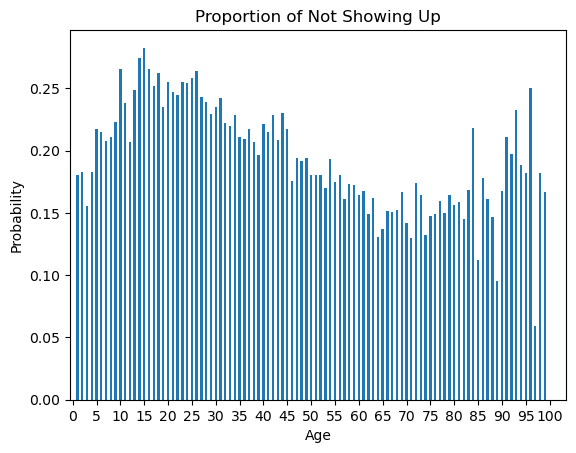

In [24]:
prob_dict = {"Age": [],
             "Prob": []}
for age in sorted(df.Age.unique()):
    df_age = df_clean[df_clean["Age"] == age]
    noshow_age = df_age[df_age["No-show"] == "Yes"]
    if len(df_age) > 0:
        prob_noshow_age = len(noshow_age)/len(df_age)
        prob_dict["Age"].append(age)
        prob_dict["Prob"].append(prob_noshow_age)
    else:
        prob_dict["Age"].append(age)
        prob_dict["Prob"].append(0)

pd.DataFrame(prob_dict).plot(kind = "bar",
       x = "Age",
       title = "Proportion of Not Showing Up",
       legend = False,
       xlabel = "Age",
       ylabel = "Probability",
       rot = 0,
       xticks = np.arange(0,103, 5));

From the bar chart above, we see teenagers, between 10 to 20 years old, and elder patients, who is more than 90 years old, are more likely not to show up to their appointment.
### Is the neighbourhood related to not showing up?

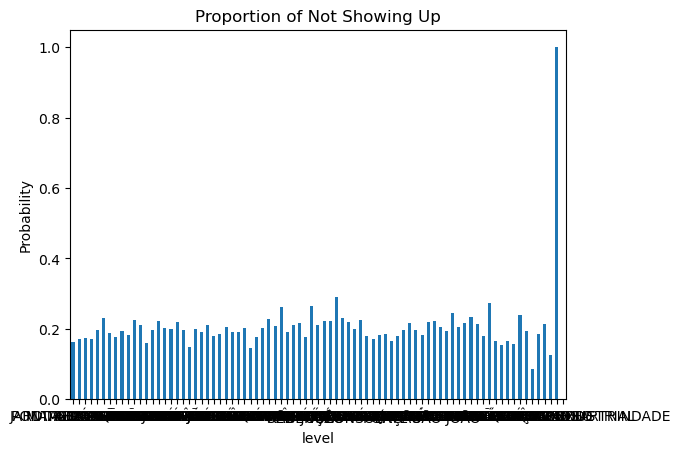

In [25]:
plot_NoShowProb(cat_NoShowProb("Neighbourhood"))

In [26]:
df_clean["Neighbourhood"].value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64

As we can see from above, we have 81 different categories for `Neighbourhood` column. The bar chart doesn't show too much difference between these neighbourhood regards to whether or not patients will not show up to their appointment. Further information needed.
### Is the enrollment in Bolsa Familia related to not showing up?

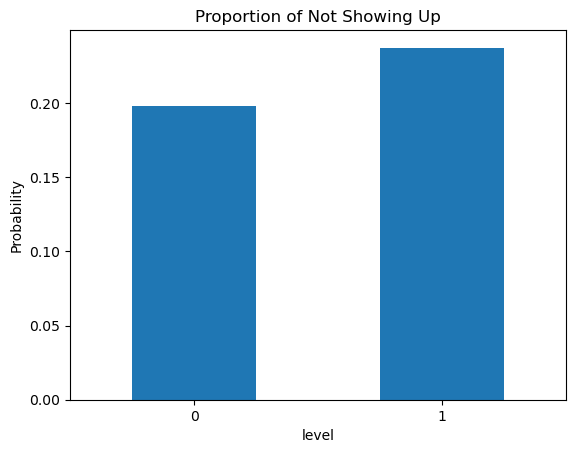

In [27]:
plot_NoShowProb(cat_NoShowProb("Scholarship"))

In [28]:
twoTTest("Scholarship", 1, 0)

Sample Standard Error: 0.004299248299118855
The best estimate is: -0.039309660580066685
Computed Test Statistics is -9.143379922514205
Computed P-value is 6.053029476320886e-20


Yes. We can be 99.9% confident that enrollment in Bolsa Familia program is related to patients not showing up to their appointment. The bar chart shows patients with enrollment is more likely not to show up to their appointment.

### Is Hipertension related to not showing up?

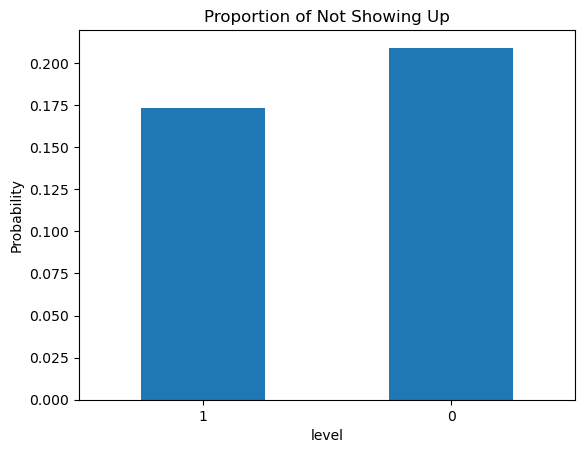

In [29]:
plot_NoShowProb(cat_NoShowProb("Hipertension"))

In [30]:
twoTTest("Hipertension", 1, 0)

Sample Standard Error: 0.0030736444087811426
The best estimate is: 0.035987253723635676
Computed Test Statistics is 11.708333475669185
Computed P-value is 1.1552803362612624e-31


Yes, we are 99.9% confident that patients with no Hipertension is more likely not to show up to their appointments.
### Is Diabetes related to not showing up?

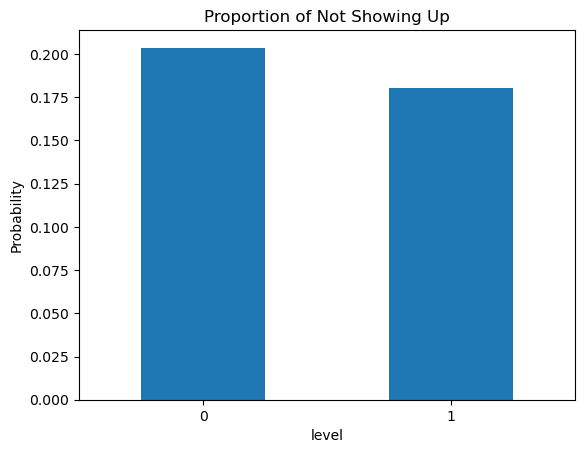

In [31]:
plot_NoShowProb(cat_NoShowProb("Diabetes"))

In [32]:
twoTTest("Diabetes", 1, 0)

Sample Standard Error: 0.0044748347631585715
The best estimate is: 0.023578177497374647
Computed Test Statistics is 5.269061036955907
Computed P-value is 1.3712336695640659e-07


Yes, we are 99.9% confident that patients with no Diabetes are more likely not to show up to their appointments.
### Is Alcoholism related to not showing up?

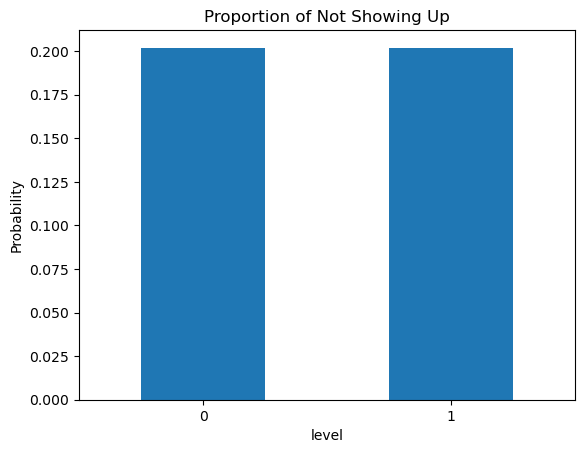

In [33]:
plot_NoShowProb(cat_NoShowProb("Alcoholism"))

In [34]:
twoTTest("Alcoholism", 1, 0)

Sample Standard Error: 0.007027482594698118
The best estimate is: 0.00044171131466183566
Computed Test Statistics is 0.06285484292697995
Computed P-value is 0.9498820938241513


From the bar chart we can't see significant difference between Alcoholism and none for not showing up to their doctor appointments. Result from t-test supports this conclusion.
### Is Handcap Level related to not showing up?

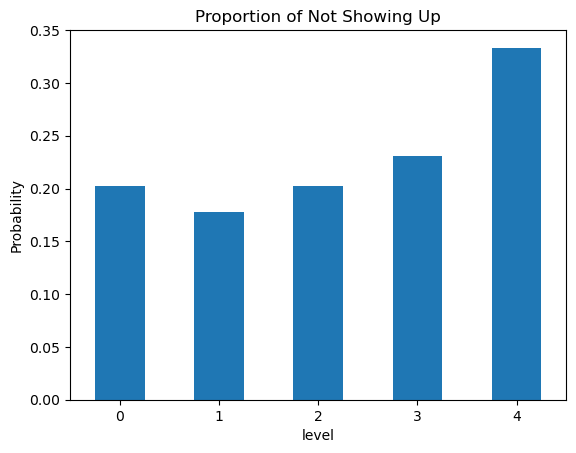

In [35]:
plot_NoShowProb(cat_NoShowProb("Handcap"))

Yes. From the bar chart, the higher level the Handcap is, the more likely that patients are not to show up to their appointments, except for Handcap level "0".
### Is SMS related to patients not showing up?

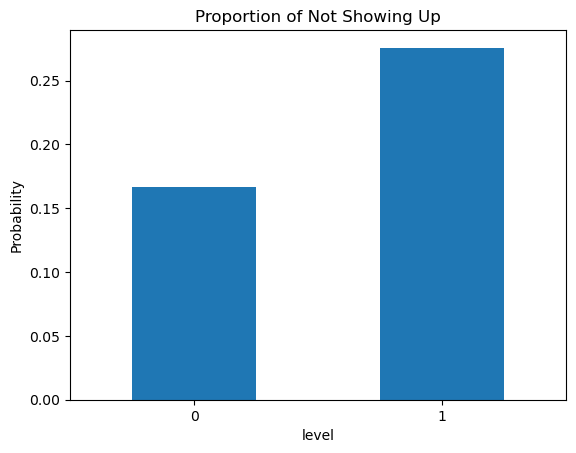

In [36]:
plot_NoShowProb(cat_NoShowProb("SMS_received"))

In [37]:
twoTTest("SMS_received", 1, 0)

Sample Standard Error: 0.0028792650605962648
The best estimate is: -0.10874895564093315
Computed Test Statistics is -37.769692387547124
Computed P-value is 0.0


Yes. We are 99.9% confident that the two groups have different proportions of patients for not showing up to their appointment. From the bar chart, patients who received SMS do not show less probability of not showing up. On the contrast, they are more likely not to show up to their appointment.

<a id='conclusions'></a>
## Conclusions
- **No relationship**: `Gender`, `Neighbourhood`, and `Alcoholism` is not related to whether patients will not show up to their appointment. 
- For **further prediction**, we might consider patients whose `Age` are between 10-20 or above 90, `ScheduledDay` is more than 160 days ago, and those who had `Hipertension`, `Diabetes`, `Scholarship` in Bolsa Familia, higher `Handcap` level, also those who are `SMS_received`.

**Additional Research**
- We have too many different `Neighbourhood` values, as a result we cannot conclude some valuable insight from this variable. Further information about location, for example, city/state/state, or commuting time to hospitals, would be helpful.
- `SMS_received` column implies contrary results to what we expected, that was SMS might help to prevent patients from not showing up to their appointment. So check the data resource of columns `SMS_received` and `No-show` is suggested.

## Submitting your Project 

In [38]:
# Running this cell will execute a bash command to convert this notebook to an .html file
!python -m nbconvert --to html Investigate_a_Dataset.ipynb

[NbConvertApp] Converting notebook Investigate_a_Dataset.ipynb to html
[NbConvertApp] Writing 911917 bytes to Investigate_a_Dataset.html
